# Implementation of Finite Mixture Model

<details>
  <summary>Table of Contents</summary>
  <ol>
    <li>
      Import Needed Filepaths and Libraries
    </li>
    <li>
    Load Dataset Into Pandas DataFrame
    </li>
    <li>
    Define Response Variable `y`
    </li>
    <li>
    Set Up Reproducible Random Number Generator
    </li>
    <li>
      Setting Up Mixture Model
      <ul>
        <li>Initial Parameters</li>
        <li>Setting Priors</li>
      </ul>
    </li>
    <li>Gibbs Sampler Implementation
      <ul>
        <li>Gibbs Sampler Updates</li>
      </ul>
</li>
  </ol>
</details>

## Import Needed Filepaths and Libraries

In [449]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy import stats
from texas_gerrymandering_hb4.config import FINAL_CSV, IMAGES_DIR


## Load Dataset Into Pandas DataFrame
Our processed dataset is read into a Pandas DataFrame.

In [450]:
df = pd.read_csv(FINAL_CSV)


## Prepare Outcome Variable
Compactness metrics are a widely-accepted indicator of gerrymandering. The PCA-weighted average of compactness metrics in our dataset, labeled as 'compactness_index' in our Pandas DataFrame, will be the outcome for the mixture. Compactness index values near 1 are considered "compact/not gerrymandered" while values near 0 are labeled "non-compact/gerrymandered".

### Define Which Columns in Dataset Contain Compactness Metrics

In [451]:
compactness_cols = [
    "polsby_popper",
    "reock",
    "convex_hull_ratio",
    "schwartzberg",
]

### Obtain Matrix of Compactness Metrics from DataFrame

In [452]:
X = df[compactness_cols].values

### Standardizing Compactness Metrics to Mean 0 and Variance 1

In [453]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Obtain First Principal Component Scores

In [454]:
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_std).flatten()

### Clarify that High Compactness Indicates Greater Compactness/Less Gerrymandering

In [455]:
if np.corrcoef(pc1, df["polsby_popper"].values)[0, 1] < 0:
    pc1 = -pc1

### Rescale Principal Component 1 to [0,1]

In [456]:
pc1_min, pc1_max = pc1.min(), pc1.max()
compactness_index = (pc1 - pc1_min) / (pc1_max - pc1_min)

### Store Compactness Index in DataFrame

In [457]:
df["compactness_index"] = compactness_index

### Defining Response Variable `y`

In [458]:
y = df["compactness_index"].values

### Defining Sample Size
* `n` denotes the sample size, which is the number of Congressional districts in Texas (38).

In [459]:
n = len(y)

## Scaled Inverse-$\chi^2$ Sampler
* This is the conjugate prior for the variance in the normal model.
* This will be used to update $\sigma_1^2$ and $\sigma_2^2$ in the Gibbs sampler.

In [460]:
def rinvchisq(df, scale):
    return df * scale / np.random.chisquare(df)


### Set Up Reproducible Random Number Generator

In [461]:
np.random.seed(123)

### Initial Parameters
* These parameters represent starting guesses for the Gibbs sampler.

#### Initialize $\lambda$
`lambda` ($\lambda$) is the mixing proportion. Starting from a place of ignorance, we assume a perfect mix between the two, and that our means are the sample means and our variances are the sample variances. $\lambda$ is set to 0.5 to serve as a neutral initial guess.

In [462]:
_lambda = 0.5

#### Initialize Means: $\mu_1$ and $\mu_2$
* `mu_1` and `mu_2` represent the initial means for each component.
* Initial parameters based on the data help circumvent warmup challenges.

In [463]:
mu_1 = np.mean(y)
mu_2 = np.mean(y)

#### Initialize Variances: $\sigma^2_1$ and $\sigma^2_2$
* `sigma_squared_1` and `sigma_squared_2` are the initial variances for each component.
* The initial component variances are the sample variance of the compactness index.
* "Bayesian Data Analysis" (Third Edition) encourages inital parameters based on data.

In [464]:
sigma_squared_1 = np.var(y,ddof=1)
sigma_squared_2 = np.var(y, ddof=1)

#### Setting Priors for $\lambda$: $\alpha_1$ and $\alpha_2$
* `alpha_1` and `alpha_2` are the priors for lambda.
$$\lambda \sim Beta(\alpha_2, \alpha_2)$$
Because the prior for lambda is Beta(2,2), `alpha_1` and `alpha_2` are both set to 2.
* This is a conjugate prior. Also, as a reminder, Beta(2,2) is also a Dirchilet distribution. What is beneficial about this is that the probability of obtaining 0 or 1, which is a degenerate model, is 0. Hence, as you get closer to 0 or 1, the likelihood is tiny. As a result, the problem is pushed further away from a degenerate value, so they become less likely to accidently become a point of convergence.

In [465]:
alpha_1 = 2.0
alpha_2 = 2.0

#### Setting Priors for Means: $\mu_1$ and $\mu_2$
* The means `m0_1` and `mu0_2` are coming from the same distribution.
* Keep in mind that compactness index is between 0 and 1.

In [466]:
mu0_1 = 0.5
mu0_2 = 0.5

#### Setting Priors for Variances: $\sigma_1^2$ and $\sigma_2^2$

In [467]:
sigma_0_squared_1 = 0.25**2
sigma_0_squared_2 = 0.25**2

#### Setting Priors for Degrees of Freedom

In [468]:
degrees_of_freedom0_1 = 2
degrees_of_freedom0_2 = 2

### Gibbs Sampler Parameters

In [469]:
iterations = 1000
warmup = 500

### Storage for Samples

In [470]:
lambda_samples = np.zeros(iterations)
mu1_samples = np.zeros(iterations)
mu2_samples = np.zeros(iterations)
sigma_squared_1_samples = np.zeros(iterations)
sigma_squared_2_samples = np.zeros(iterations)
z_samples = np.zeros((iterations, n), dtype=int)

## Gibbs Sampler Implementation
* The process for the Gibbs sampler involves initializing parameters, iterative sampling, and continuing the iterations until convergence.
* The benefits of the Gibbs sampler are that it handles complex, high-dimensional distributions and is easier to implement than direct sampling methods.

In [471]:
for i in range(iterations):
    # ---- Update z (component membership for each district) ----
    lik_1 = _lambda * norm.pdf(y, loc=mu_1, scale=np.sqrt(sigma_squared_1))
    lik_2 = (1 - _lambda) * norm.pdf(y, loc=mu_2, scale=np.sqrt(sigma_squared_2))
    z_probs = lik_1 / (lik_1 + lik_2)
    z = np.random.binomial(1, z_probs)  # 1 = component 1, 0 = component 2

    # ---- Update lambda ----
    alpha_lambda_post = alpha_1 + np.sum(z)
    beta_lambda_post = alpha_2 + (n - np.sum(z))
    _lambda = np.random.beta(alpha_lambda_post, beta_lambda_post)

    # ---- Update mu_1 ----
    n1 = np.sum(z)
    if n1 > 0:
        y1_mean = np.mean(y[z == 1])
        # *** FIXED: use sigma_squared_1 in BOTH places ***
        mu1_post_mean = ((mu0_1 / sigma_0_squared_1) + n1 * y1_mean / sigma_squared_1) / \
                        (1 / sigma_0_squared_1 + n1 / sigma_squared_1)
        mu1_post_sd = np.sqrt(1 / (1 / sigma_0_squared_1 + n1 / sigma_squared_1))
    else:
        mu1_post_mean = mu0_1
        mu1_post_sd = np.sqrt(sigma_0_squared_1)
    mu_1 = np.random.normal(mu1_post_mean, mu1_post_sd)
 # ---- Update mu_2 ----
    n2 = n - n1
    if n2 > 0:
        y2_mean = np.mean(y[z == 0])
        mu2_post_mean = ((mu0_2 / sigma_0_squared_2) + n2 * y2_mean / sigma_squared_2) / \
                        (1 / sigma_0_squared_2 + n2 / sigma_squared_2)
        mu2_post_sd = np.sqrt(1 / (1 / sigma_0_squared_2 + n2 / sigma_squared_2))
    else:
        mu2_post_mean = mu0_2
        mu2_post_sd = np.sqrt(sigma_0_squared_2)
    mu_2 = np.random.normal(mu2_post_mean, mu2_post_sd)

    # ---- Update sigma_1_sq (scaled inverse-chi-squared) ----
    nu1_post = degrees_of_freedom0_1 + n1
    if n1 > 0:
        ss1 = np.sum((y[z == 1] - mu_1) ** 2)
    else:
        ss1 = 0.0
    sigma1_post_scale = (degrees_of_freedom0_1 * sigma_0_squared_1 + ss1) / nu1_post
    sigma_1_sq = rinvchisq(nu1_post, sigma1_post_scale)

    # ---- Update sigma_2_sq (scaled inverse-chi-squared) ----
    nu2_post = degrees_of_freedom0_2 + n2
    if n2 > 0:
        ss2 = np.sum((y[z == 0] - mu_2) ** 2)
    else:
        ss2 = 0.0
    sigma2_post_scale = (degrees_of_freedom0_2 * sigma_0_squared_2 + ss2) / nu2_post
    sigma_2_sq = rinvchisq(nu2_post, sigma2_post_scale)
# ---- IMPORTANT: feed σ² back into the state ----
    sigma_squared_1 = sigma_1_sq
    sigma_squared_2 = sigma_2_sq

    # ---- Store samples ----
    lambda_samples[i] = _lambda
    mu1_samples[i] = mu_1
    mu2_samples[i] = mu_2
    sigma_squared_1_samples[i] = sigma_1_sq
    sigma_squared_2_samples[i] = sigma_2_sq
    z_samples[i, :] = z


### Discard Warmup Draws

In [472]:
lambda_post = lambda_samples[warmup:]
mu1_post = mu1_samples[warmup:]
mu2_post = mu2_samples[warmup:]
sigma1_post = sigma_squared_1_samples[warmup:]
sigma2_post = sigma_squared_2_samples[warmup:]
z_post = z_samples[warmup:, :]

## Calculate Means for Each Parameter

In [473]:
print("Posterior mean lambda:", lambda_post.mean())
print("Posterior mean mu_1 (compactness):", mu1_post.mean())
print("Posterior mean mu_2 (compactness):", mu2_post.mean())
print("Posterior mean sigma1^2:", sigma1_post.mean())
print("Posterior mean sigma2^2:", sigma2_post.mean())


Posterior mean lambda: 0.4876197372189006
Posterior mean mu_1 (compactness): 0.4105080565047383
Posterior mean mu_2 (compactness): 0.4035088477471154
Posterior mean sigma1^2: 0.06490880902675393
Posterior mean sigma2^2: 0.05781289880397148


## Plotting Histograms of Posterior Samples with Means

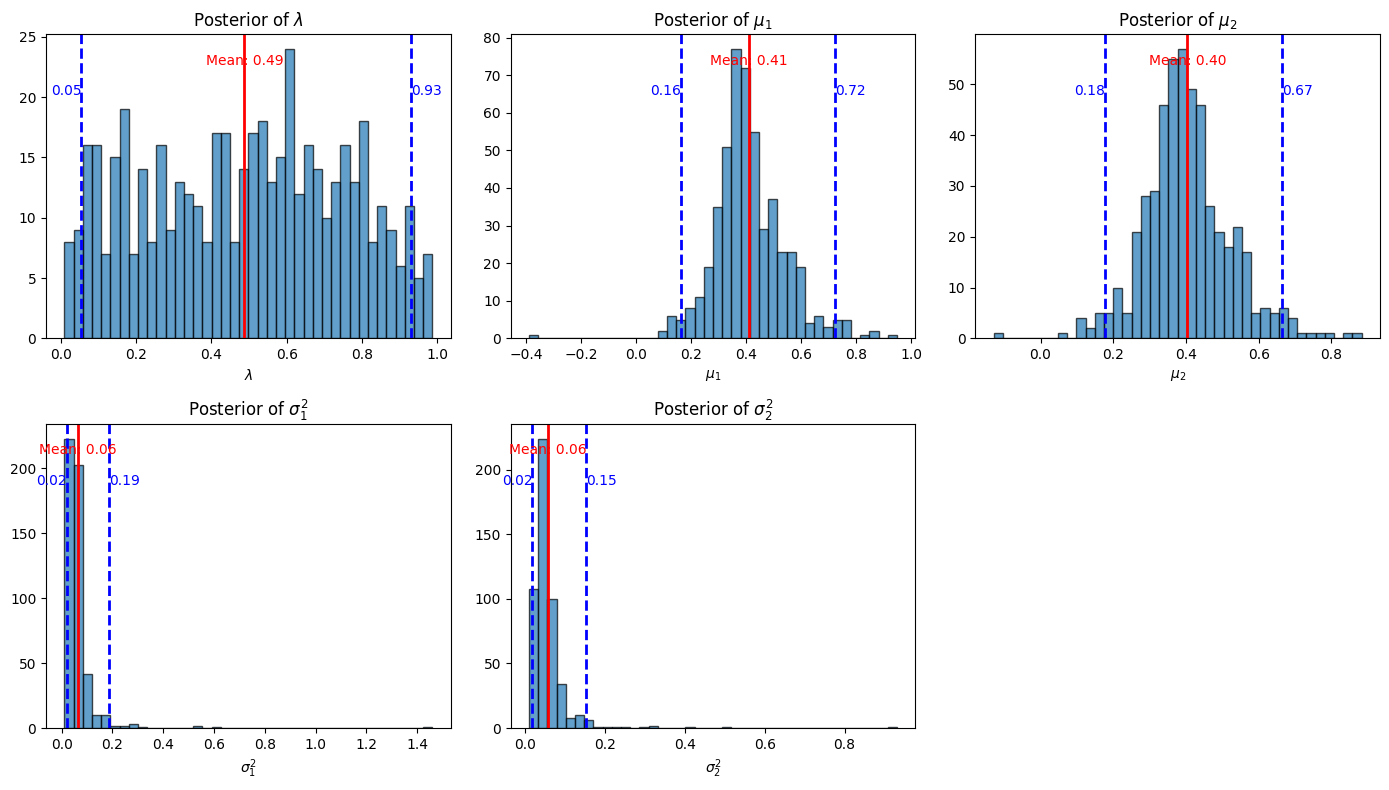

In [474]:
# Histograms of posterior samples with means + 95% credible intervals
posteriors = [
    (r"$\lambda$",    lambda_post),
    (r"$\mu_1$",      mu1_post),
    (r"$\mu_2$",      mu2_post),
    (r"$\sigma_1^2$", sigma1_post),
    (r"$\sigma_2^2$", sigma2_post),
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for ax, (name, samples) in zip(axes, posteriors):
    # Histogram
    ax.hist(samples, bins=40, edgecolor="black", alpha=0.7)

    # Posterior mean
    mean_val = samples.mean()
    ax.axvline(mean_val, color="red", linewidth=2, label="Mean")

    # 95% credible interval
    lower = np.quantile(samples, 0.025)
    upper = np.quantile(samples, 0.975)

    ax.axvline(lower, color="blue", linestyle="--", linewidth=2, label="95% CI")
    ax.axvline(upper, color="blue", linestyle="--", linewidth=2)

    # Text annotations
    ymax = ax.get_ylim()[1]

    ax.text(mean_val, ymax * 0.90, f"Mean: {mean_val:.2f}",
            color="red", ha="center")

    ax.text(lower, ymax * 0.80, f"{lower:.2f}",
            color="blue", ha="right")

    ax.text(upper, ymax * 0.80, f"{upper:.2f}",
            color="blue", ha="left")

    ax.set_title(f"Posterior of {name}")
    ax.set_xlabel(name)

# Remove unused subplot
for j in range(len(posteriors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(IMAGES_DIR/"histograms_posterior_samples.png")
plt.show()


### Print Summary Statistics

In [475]:
# Summary statistics for posterior samples (analogous to R's summary())
def summarize_posterior(samples):
    samples = np.asarray(samples)
    return {
        "mean": float(np.mean(samples)),
        "sd": float(np.std(samples, ddof=1)),
        "2.5%": float(np.quantile(samples, 0.025)),
        "25%": float(np.quantile(samples, 0.25)),
        "50%": float(np.quantile(samples, 0.50)),
        "75%": float(np.quantile(samples, 0.75)),
        "97.5%": float(np.quantile(samples, 0.975)),
    }

summary_stats = pd.DataFrame.from_dict(
    {
        "lambda":    summarize_posterior(lambda_post),
        "mu_1":      summarize_posterior(mu1_post),
        "mu_2":      summarize_posterior(mu2_post),
        "sigma_1_sq": summarize_posterior(sigma1_post),
        "sigma_2_sq": summarize_posterior(sigma2_post),
    },
    orient="index"
)

summary_stats


,mean,sd,2.5%,25%,50%,75%,97.5%
lambda,0.487620,0.262154,0.054972,0.267716,0.508944,0.702017,0.930643
mu_1,0.410508,0.129711,0.163315,0.338387,0.394788,0.481797,0.721612
mu_2,0.403509,0.118955,0.177450,0.337774,0.392898,0.468032,0.665282
sigma_1_sq,0.064909,0.083511,0.019523,0.035871,0.049865,0.067731,0.186985
sigma_2_sq,0.057813,0.059539,0.018313,0.034541,0.044960,0.063662,0.153100


### Posterior Predictive Simulation

In [476]:
# Number of posterior draws after warmup and number of districts
S = len(lambda_post)      # posterior iterations kept
n = len(y)                # number of districts

# y_rep[s, i] = replicated compactness for iteration s, district i
y_rep = np.zeros((S, n))

for s in range(S):
    mu1_s = mu1_post[s]
    mu2_s = mu2_post[s]
    sigma1_s = np.sqrt(sigma1_post[s])  # convert variances to std devs
    sigma2_s = np.sqrt(sigma2_post[s])

    # latent class labels for iteration s
    z_s = z_post[s, :]          # shape (n,), values 0 or 1

    # indices for each component
    idx1 = (z_s == 1)
    idx2 = ~idx1

    # simulate replicated data for each component
    if idx1.any():
        y_rep[s, idx1] = np.random.normal(
            loc=mu1_s,
            scale=sigma1_s,
            size=idx1.sum()
        )
    if idx2.any():
        y_rep[s, idx2] = np.random.normal(
            loc=mu2_s,
            scale=sigma2_s,
            size=idx2.sum()
        )


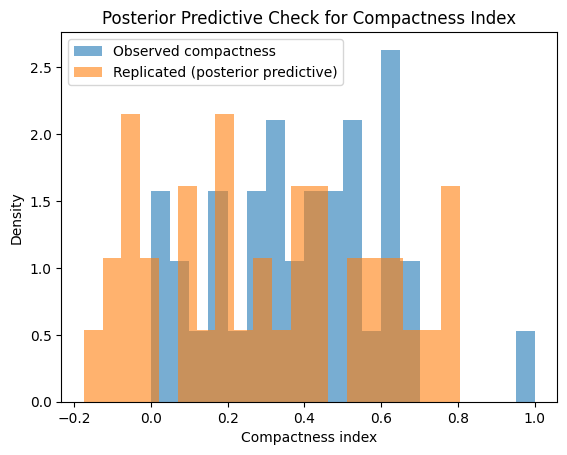

In [477]:
# %%
# Take one replicated dataset (e.g., last iteration) for a simple overlay
y_rep_single = y_rep[-1, :]

plt.hist(y, bins=20, density=True, alpha=0.6, label="Observed compactness")
plt.hist(y_rep_single, bins=20, density=True, alpha=0.6, label="Replicated (posterior predictive)")
plt.xlabel("Compactness index")
plt.ylabel("Density")
plt.title("Posterior Predictive Check for Compactness Index")
plt.legend()
plt.show()

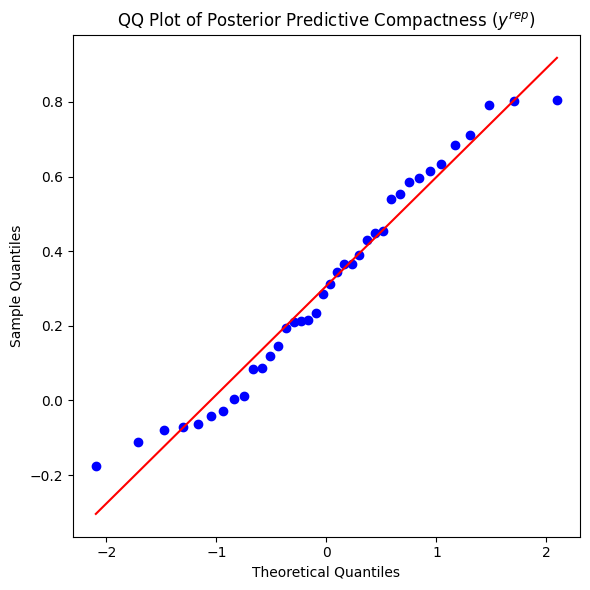

In [478]:
# QQ plot of posterior predictive replicated data (single draw)
plt.figure(figsize=(6, 6))
stats.probplot(y_rep_single, dist="norm", plot=plt)
plt.title("QQ Plot of Posterior Predictive Compactness ($y^{rep}$)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.tight_layout()
plt.show()

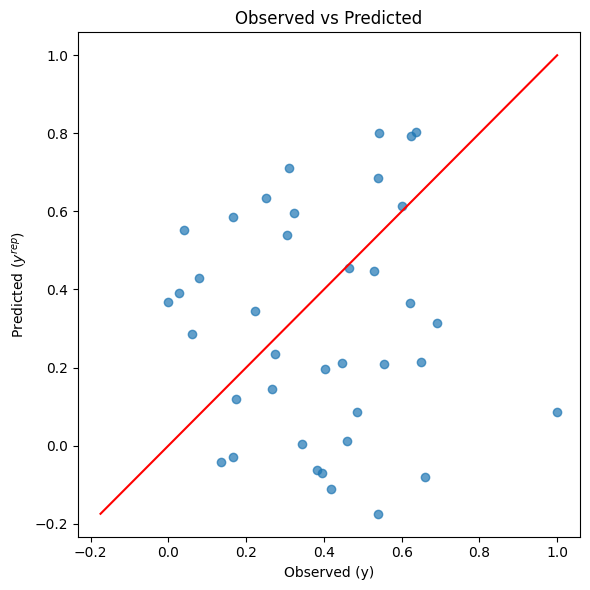

In [479]:
# %%
# Scatter plot of observed vs posterior predictive replicated compactness
plt.figure(figsize=(6, 6))
plt.scatter(y, y_rep_single, alpha=0.7)

# 45-degree reference line
min_val = min(y.min(), y_rep_single.min())
max_val = max(y.max(), y_rep_single.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red")

plt.xlabel("Observed (y)")
plt.ylabel("Predicted ($y^{rep}$)")
plt.title("Observed vs Predicted")
plt.tight_layout()
plt.show()

## Posterior Probability of Gerrymandering by District

### Determining Which Component is Gerrymandered for Each Iteration

In [480]:
post_prob_gerr = (z_post == 0).mean(axis=0)

df["post_prob_geom_gerrymandered"] = post_prob_gerr

# For backward compatibility with your previous code name:
df["post_prob_gerrymandered"] = df["post_prob_geom_gerrymandered"]

df[["district_id", "compactness_index", "post_prob_gerrymandered"]].head()

# %% [markdown]
# ## Ranking Districts By Posterior Probability

# %%
df_sorted = df.sort_values("post_prob_gerrymandered", ascending=False)
df_sorted[["district_id", "compactness_index", "post_prob_gerrymandered"]].head(20)

# %% [markdown]

,district_id,compactness_index,post_prob_gerrymandered
1,2,0.305874,0.552
3,4,0.061802,0.550
0,1,0.403531,0.542
19,20,0.250429,0.542
29,30,0.637103,0.542
20,21,0.660859,0.540
2,3,0.417277,0.534
15,16,0.537906,0.534
23,24,0.343993,0.532
5,6,0.554857,0.532


In [481]:
# For each iteration, decide which component is "low-compactness" (gerrymandered-ish)
#is_low1 = mu1_post < mu2_post                   # True if comp 1 has lower mean compactness
#gerr_label_per_iter = np.where(is_low1, 1, 0)   # 1 if comp 1 is low-compactness, else 0

In [482]:
# Posterior P(geometrically gerrymandered) for each district:
# proportion of iterations where its z equals that iteration's gerrymandered label
#post_prob_geom_gerr = np.mean(
#    z_post == gerr_label_per_iter[:, None],
#    axis=0
#)

In [483]:
# Store in dataframe
#df["post_prob_geom_gerrymandered"] = post_prob_geom_gerr

# For backward compatibility with your previous code name:
#df["post_prob_gerrymandered"] = df["post_prob_geom_gerrymandered"]

#df[["district_id", "compactness_index", "post_prob_gerrymandered"]].head()


## Ranking Districts By Posterior Probability

### Sort Districts from Most Likely to Least Likely to Be Gerrymandered

In [484]:
df_sorted = df.sort_values("post_prob_gerrymandered", ascending=False)

### Choose Columns to Include

In [485]:
cols_to_show = [
    "district_id",
    "compactness_index",
    "post_prob_gerrymandered",
]

In [486]:
# Optional columns – only include if they’re actually present
for c in ["pct_minority", "dem_share"]:
    if c in df_sorted.columns:
        cols_to_show.append(c)

### Show 20 Districts with the Highest Probability of Being Gerrymandered

In [487]:
df_sorted[cols_to_show].head(20)

,district_id,compactness_index,post_prob_gerrymandered,dem_share
1,2,0.305874,0.552,0.399379
3,4,0.061802,0.550,0.405732
0,1,0.403531,0.542,0.252671
19,20,0.250429,0.542,0.666367
29,30,0.637103,0.542,0.751580
20,21,0.660859,0.540,0.404610
2,3,0.417277,0.534,0.403698
15,16,0.537906,0.534,0.584138
23,24,0.343993,0.532,0.432951
5,6,0.554857,0.532,0.404557
